# Will have here a compendium of all the analysis that will make it into chapter 4 of my thesis

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


In [131]:
sns.set_context("paper", font_scale=1.6)

In [61]:
df = pd.read_pickle("./data/pre-processed-metrics-dataframe.pkl")

In [62]:
df.scheduler.unique()

array(['DYTAS[navigation=Front,sorting=DFS,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=All,sorting=DFS,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=All,sorting=Khan,multicore=SkipActiveProcessors]',
       'DYTAS[navigation=Front,sorting=DFS,multicore=UseAllCores]',
       'DYTAS[navigation=Front,sorting=Khan,multicore=UseAllCores]',
       'DYTAS[navigation=All,sorting=DFS,multicore=UseAllCores]',
       'DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]', 'HEFT',
       'DLS', 'DynamicList[task=CompSize,resource=Speed,cores=MaxCores]',
       'DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]'],
      dtype=object)

Selecting Only the primary 4 algorithms for my thesis

In [63]:
algorithms = [
    "HEFT",
    "DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]",
    "DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]",
    "DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]"
]

df = df[df.scheduler.isin(algorithms)].reset_index(drop=True)

In [67]:
df.index

RangeIndex(start=0, stop=710208, step=1)

Renaming the algorithms.

In [64]:
rename_map = {
    "HEFT": "HEFT",
    "DynamicList[task=BottomLevel,resource=Speed,cores=MaxCores]":"Dynamic List",
    "DYTAS[navigation=Front,sorting=Khan,multicore=SkipActiveProcessors]": "DYTAS",
    "DYTAS[navigation=All,sorting=Khan,multicore=UseAllCores]": "Proposed-DYTAS"
}
df["scheduler"] = df.scheduler.map(rename_map)

In [65]:
df.scheduler.unique()

array(['DYTAS', 'Proposed-DYTAS', 'HEFT', 'Dynamic List'], dtype=object)

Making a consistent color map for each of them

In [7]:
cmap = {
    "HEFT":"#49c8d8",
    "Dynamic List":"#cf5b5b",
    "DYTAS":"#88d58b",
    "Proposed-DYTAS":"#cfa65b",
}
hue_order = list(cmap.keys())

# Descriptive Overview

# SLR Distribution

In [8]:
df["SLR"].std()

1678.6364444442477

In [52]:
sum(df["makespan"] < 0) # Making sure there are no negative makespans

0

In [54]:
sum(df["makespan"] < 1) # Number of fractional makespan values

317

<Axes: xlabel='SLR'>

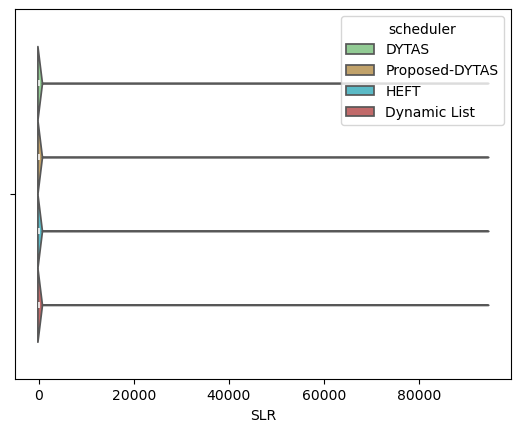

In [9]:
sns.violinplot(data=df, x="SLR", hue="scheduler", palette=cmap)

Values are heavily skewed. For the sake of visualization, the Median Absolute Deviation (MAD) will be used to remove outliers.

In [68]:
def detect_outliers_mad(data, threshold=3.5):
    median = np.median(data)
    mad = np.median(np.abs(data-median))
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    modified_z_scores = 0.6745 * (data - median) / mad
    return np.abs(modified_z_scores) > threshold



In [70]:
df["makespan_outlier"] = df.groupby("scheduler")["makespan"].transform(detect_outliers_mad)

In [11]:
# def outlier_detection_helper(x):
#     outliers = detect_outliers_mad(x["makespan"])

#     return x[~outliers]


# df_mad_makespan = df.groupby("scheduler")[
#     list(df.columns)
# ].apply(outlier_detection_helper).reset_index(drop=True)

In [25]:
# common_test_ids = set(df_mad_makespan[df_mad_makespan['scheduler'] == algorithms[0]]['test_id'])
# print(len(common_test_ids))
# for alg in algorithms[1:]:
#     inst = set(df_mad_makespan[df_mad_makespan['scheduler'] == alg]['test_id'])
#     common_test_ids = common_test_ids.intersection(inst)
#     print(len(common_test_ids))

# df_final = df_mad_makespan[df_mad_makespan['test_id'].isin(common_test_ids)]
# df_final

177174
0
0
0


,dag,system,scheduler,makespan,exec_time,run_stats.total_task_time,run_stats.total_network_traffic,run_stats.total_network_time,run_stats.max_used_cores,run_stats.max_cpu_utilization,...,efficiency_cores,network_bandwidth,network_latency,network_model,min_processor_speed,max_processor_speed,SLR,workflow,test_id,system_type


None of the test instances are the same after outlier removal with MAD method, thus possibly making this an unfair comparison accross the board

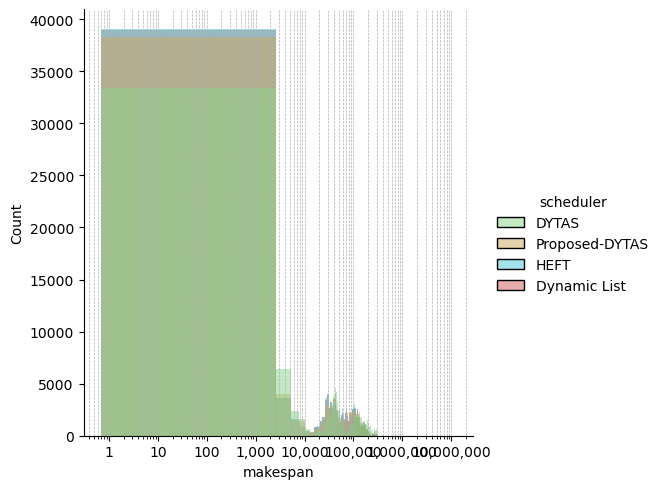

In [71]:
sns.displot(data=df, x="makespan", hue="scheduler", palette=cmap)
plt.xscale("log")  # Compress right tail
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)


This log scale makes it easier to observer why the mayority of the test instances end up with such a low makespan. A more normal distribution can start to be obsertved at around the [10000,300000] range. This slighly alights with how the outliers are removed via the MAD method.

Text(0.5, 1.0, 'Distribution of Makespan per Algorithm (manual range)')

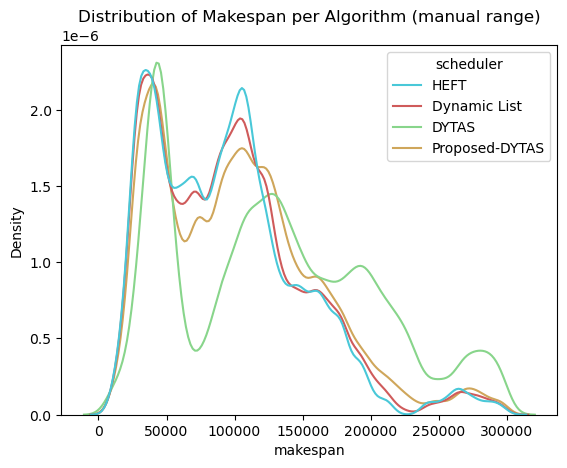

In [72]:
sns.kdeplot(df[(df.makespan >10000)&(df.makespan < 300000)], x='makespan', hue="scheduler",hue_order=hue_order,
               palette=cmap)

plt.title("Distribution of Makespan per Algorithm (manual range)")

Text(0.5, 1.0, 'Distribution of Makespan per Algorithm (manual range)')

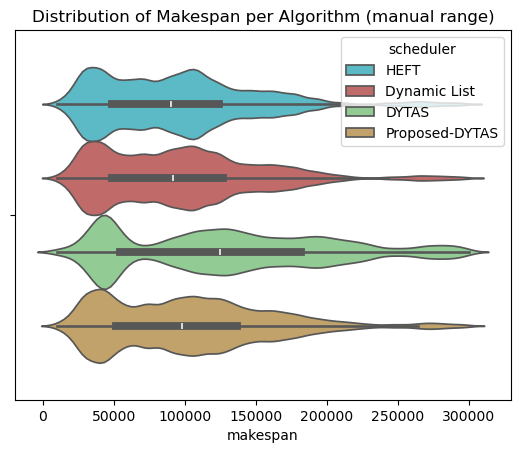

In [46]:
sns.violinplot(df[(df.makespan >10000)&(df.makespan < 300000)], x='makespan', hue="scheduler",hue_order=hue_order,
               palette=cmap)

plt.title("Distribution of Makespan per Algorithm (manual range)")


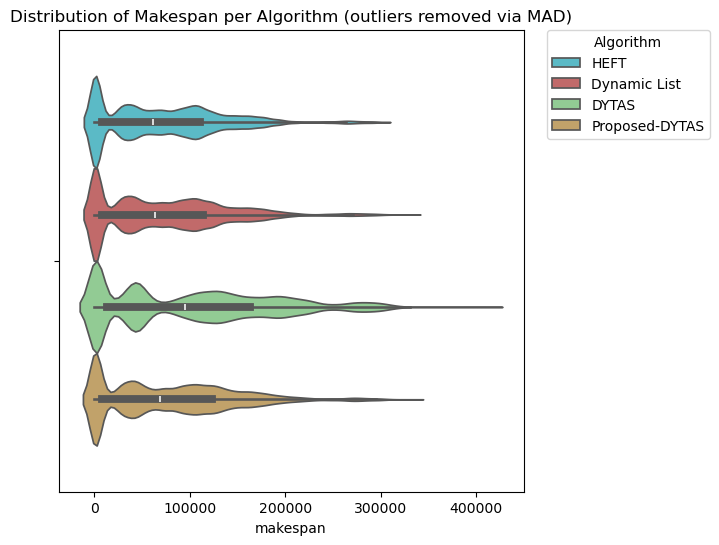

In [91]:
plt.figure(figsize=(6,6))
sns.violinplot(data=df[df.makespan_outlier == False], x="makespan", 
               hue="scheduler", 
               hue_order=hue_order,
               palette=cmap)
plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)
plt.title("Distribution of Makespan per Algorithm (outliers removed via MAD)")
plt.show()

After removing outliers with the mad method for makespan values we can more clearly visualize the distributions. It is easy to see how the medians of HEFT and Dynamic List are close together, with Dynamic List having a higher tail (more extreme values). On the other hand, we see that the median of DYTAS is the highest out of all, and has more extreme values, whilst the Improved version of DYTAS spans a lower median and extremes, which aproximates more how dynamic list is distributed.

## Testing what is impacting outlying results
To make sure it is understood why there exists certain makespan results that are grouped in such a way, and how they differ from the non outlying data.

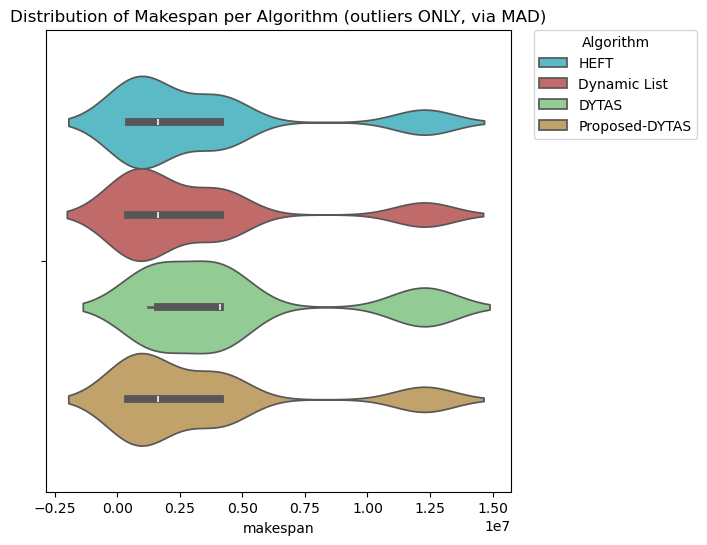

In [90]:
plt.figure(figsize=(6,6))
sns.violinplot(data=df[df.makespan_outlier == True], x="makespan", 
               hue="scheduler", 
               hue_order=hue_order,
               palette=cmap)
plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)
plt.title("Distribution of Makespan per Algorithm (outliers ONLY, via MAD)")
plt.show()

Applying random forest regressor to check what independet variables impact these the most.

In [79]:
# Encoding nominal values
vars_to_encode = ["system_type", "network_model", "workflow"]
encoder = OneHotEncoder(sparse_output=False)

encoded_features = encoder.fit_transform(df[vars_to_encode])
encoded_columns = encoder.get_feature_names_out(vars_to_encode)
df = df.join(pd.DataFrame(encoded_features, columns=encoded_columns))

In [80]:
def random_forest_regressor(df, dependent_var, independent_vars):
    scheduler_col = "scheduler"
    
    # List to store feature importance data
    feature_importance_data = []
    
    # Iterate through each unique scheduler
    for scheduler in df[scheduler_col].unique():
        # Filter data for the current scheduler
        df_scheduler = df[df[scheduler_col] == scheduler]
        
        # Separate independent and dependent variables
        X = df_scheduler[independent_vars]
        y = df_scheduler[dependent_var]
        
        # Train the Regressor
        model = RandomForestRegressor(random_state=0, n_estimators=100)
        model.fit(X, y)
        
        # Extract feature importances
        importances = model.feature_importances_
        
        # Store the results
        for i, imp in enumerate(importances):
            feature_importance_data.append({'Scheduler': scheduler,
                                            'Feature': independent_vars[i],
                                            'Importance': imp})
    
    # Convert to DataFrame for visualization
    importance_df = pd.DataFrame(feature_importance_data)
    
    # Set the figure size
    plt.figure(figsize=(12, 8))
    
    # Create a barplot with dodging to separate bars by scheduler
    sns.barplot(data=importance_df, x='Feature', y='Importance', hue='Scheduler', dodge=True)
    
    # Add labels and title
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance by Scheduler for ' + dependent_var)
    plt.legend(title='Scheduler')
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent clipping of labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [81]:
df.columns

Index(['dag', 'system', 'scheduler', 'makespan', 'exec_time',
       'run_stats.total_task_time', 'run_stats.total_network_traffic',
       'run_stats.total_network_time', 'run_stats.max_used_cores',
       'run_stats.max_cpu_utilization', 'run_stats.cpu_utilization',
       'run_stats.memory_utilization', 'run_stats.used_resource_count',
       'run_stats.cpu_utilization_used', 'run_stats.cpu_utilization_active',
       'dag_nodes', 'dag_edges', 'dag_density', 'dag_total_comp_size',
       'dag_total_transfers_size', 'dag_depth', 'dag_width',
       'dag_parallelism_degree', 'dag_critical_path_size', 'CCR', 'speedup',
       'processor_count', 'core_count', 'efficiency_processors',
       'efficiency_cores', 'network_bandwidth', 'network_latency',
       'network_model', 'min_processor_speed', 'max_processor_speed', 'SLR',
       'workflow', 'test_id', 'system_type', 'makespan_outlier',
       'system_type_heterogeneous', 'system_type_homogeneous',
       'network_model_ConstantBandwi

In [82]:
ind_variables = [
    'dag_nodes', 'dag_density',
    'CCR',
    'processor_count', 'core_count',
    'system_type_heterogeneous', 'system_type_homogeneous',
       'network_model_ConstantBandwidth', 'network_model_SharedBandwidth',
       'workflow_1000genome', 'workflow_blast', 'workflow_bwa',
       'workflow_cycles', 'workflow_epigenomics', 'workflow_montage',
       'workflow_random', 'workflow_seismology', 'workflow_soykb',
       'workflow_srasearch'
]

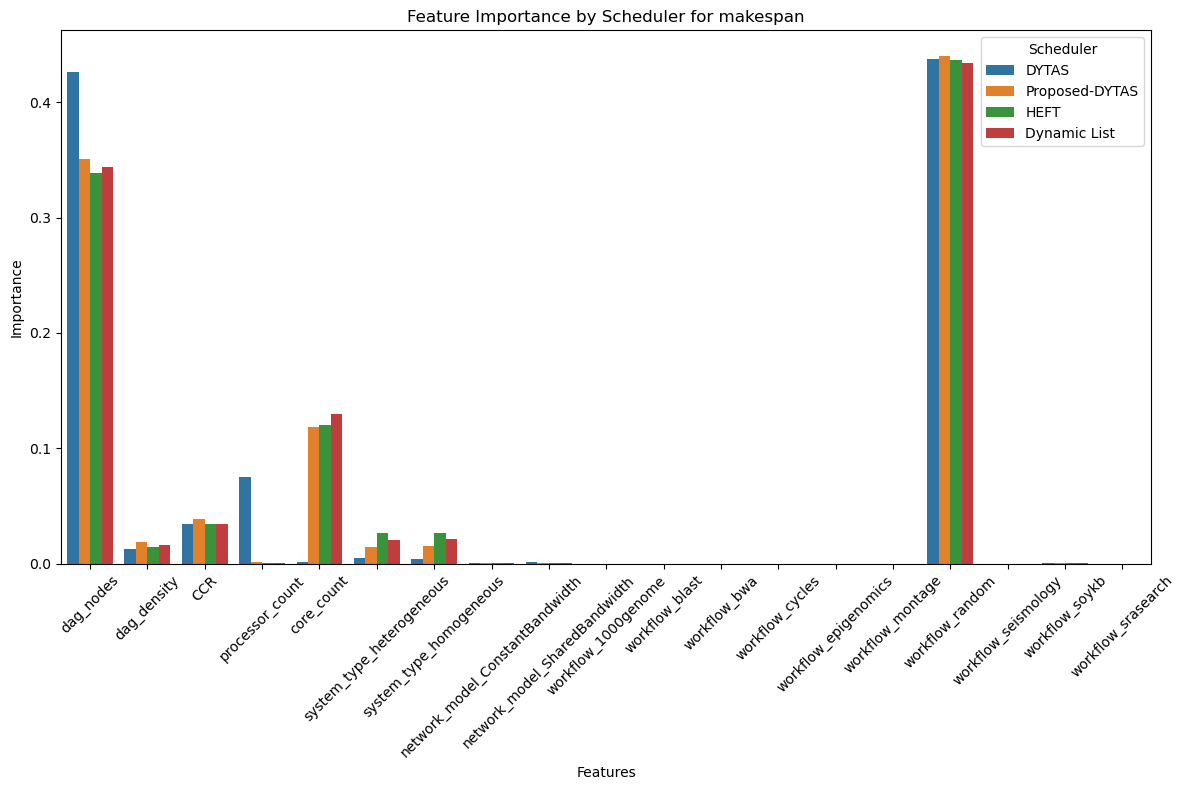

In [83]:
random_forest_regressor(df[df.makespan_outlier == False], "makespan", ind_variables)

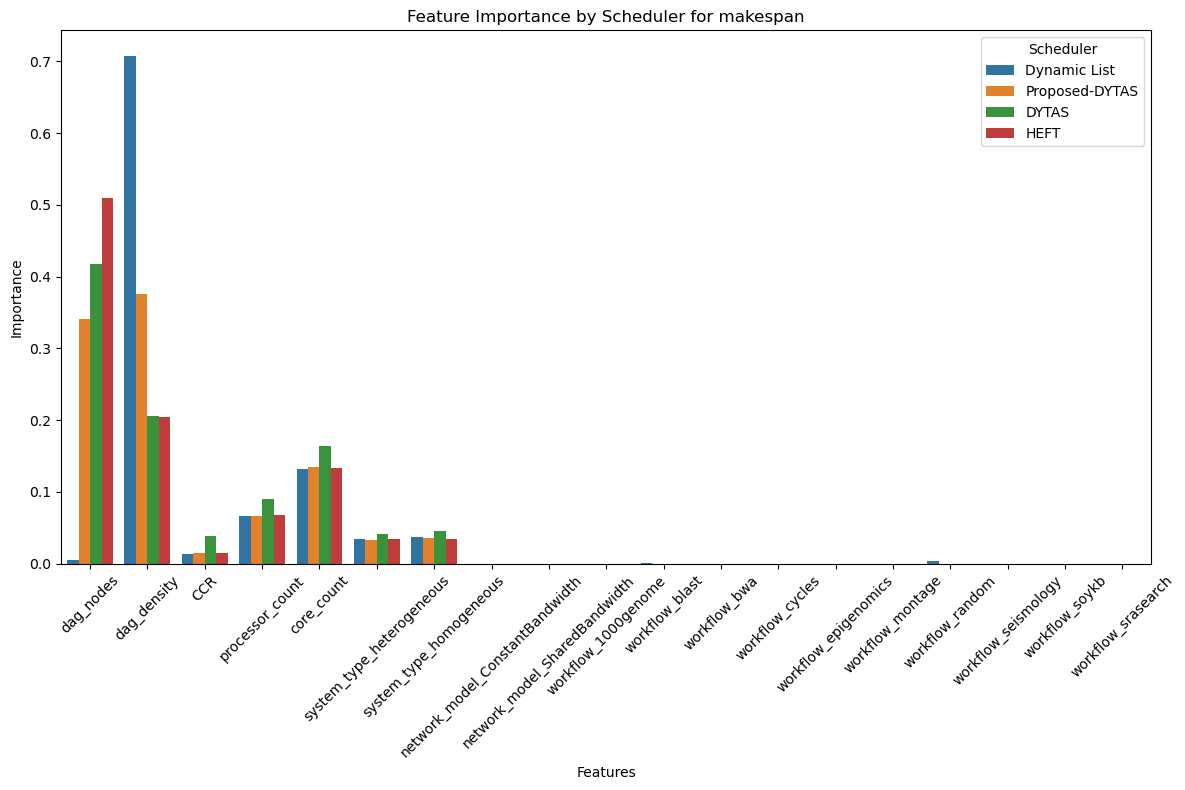

In [84]:
random_forest_regressor(df[df.makespan_outlier == True], "makespan", ind_variables)

The above values suggest that the non outlier values seem to be heavily influenced by the montage workflow. The outliers not, but seem to be more influenced by the density of the DAG.

This suggests to me that it is better to separate these distribution visualizations ber workflow instance, since I know there is a predominance of 400 DAGs that come from DAGGEN that are hevily controlle by their density.

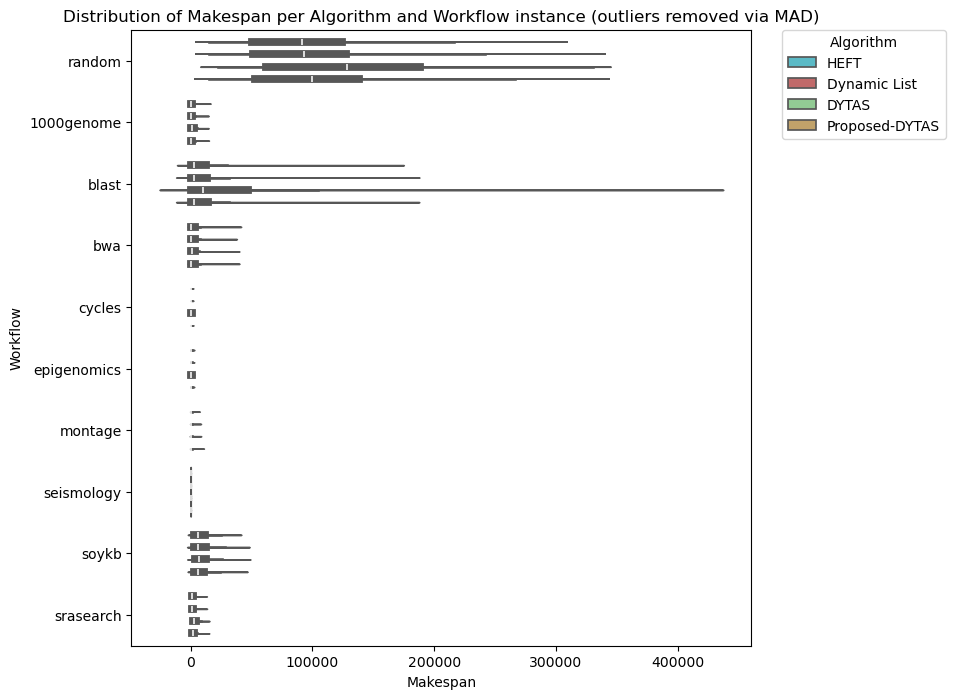

In [94]:
plt.figure(figsize=(8,8))
sns.violinplot(data=df[df.makespan_outlier == False], x="makespan", 
               hue="scheduler",
               y="workflow",
               hue_order=hue_order,
               palette=cmap)
plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)
plt.xlabel("Makespan")
plt.ylabel("Workflow")
plt.title("Distribution of Makespan per Algorithm and Workflow instance (outliers removed via MAD)")
plt.show()

The above graph further confirms that the makespan distribution should be analyzed per workflow/DAG type for better redability.

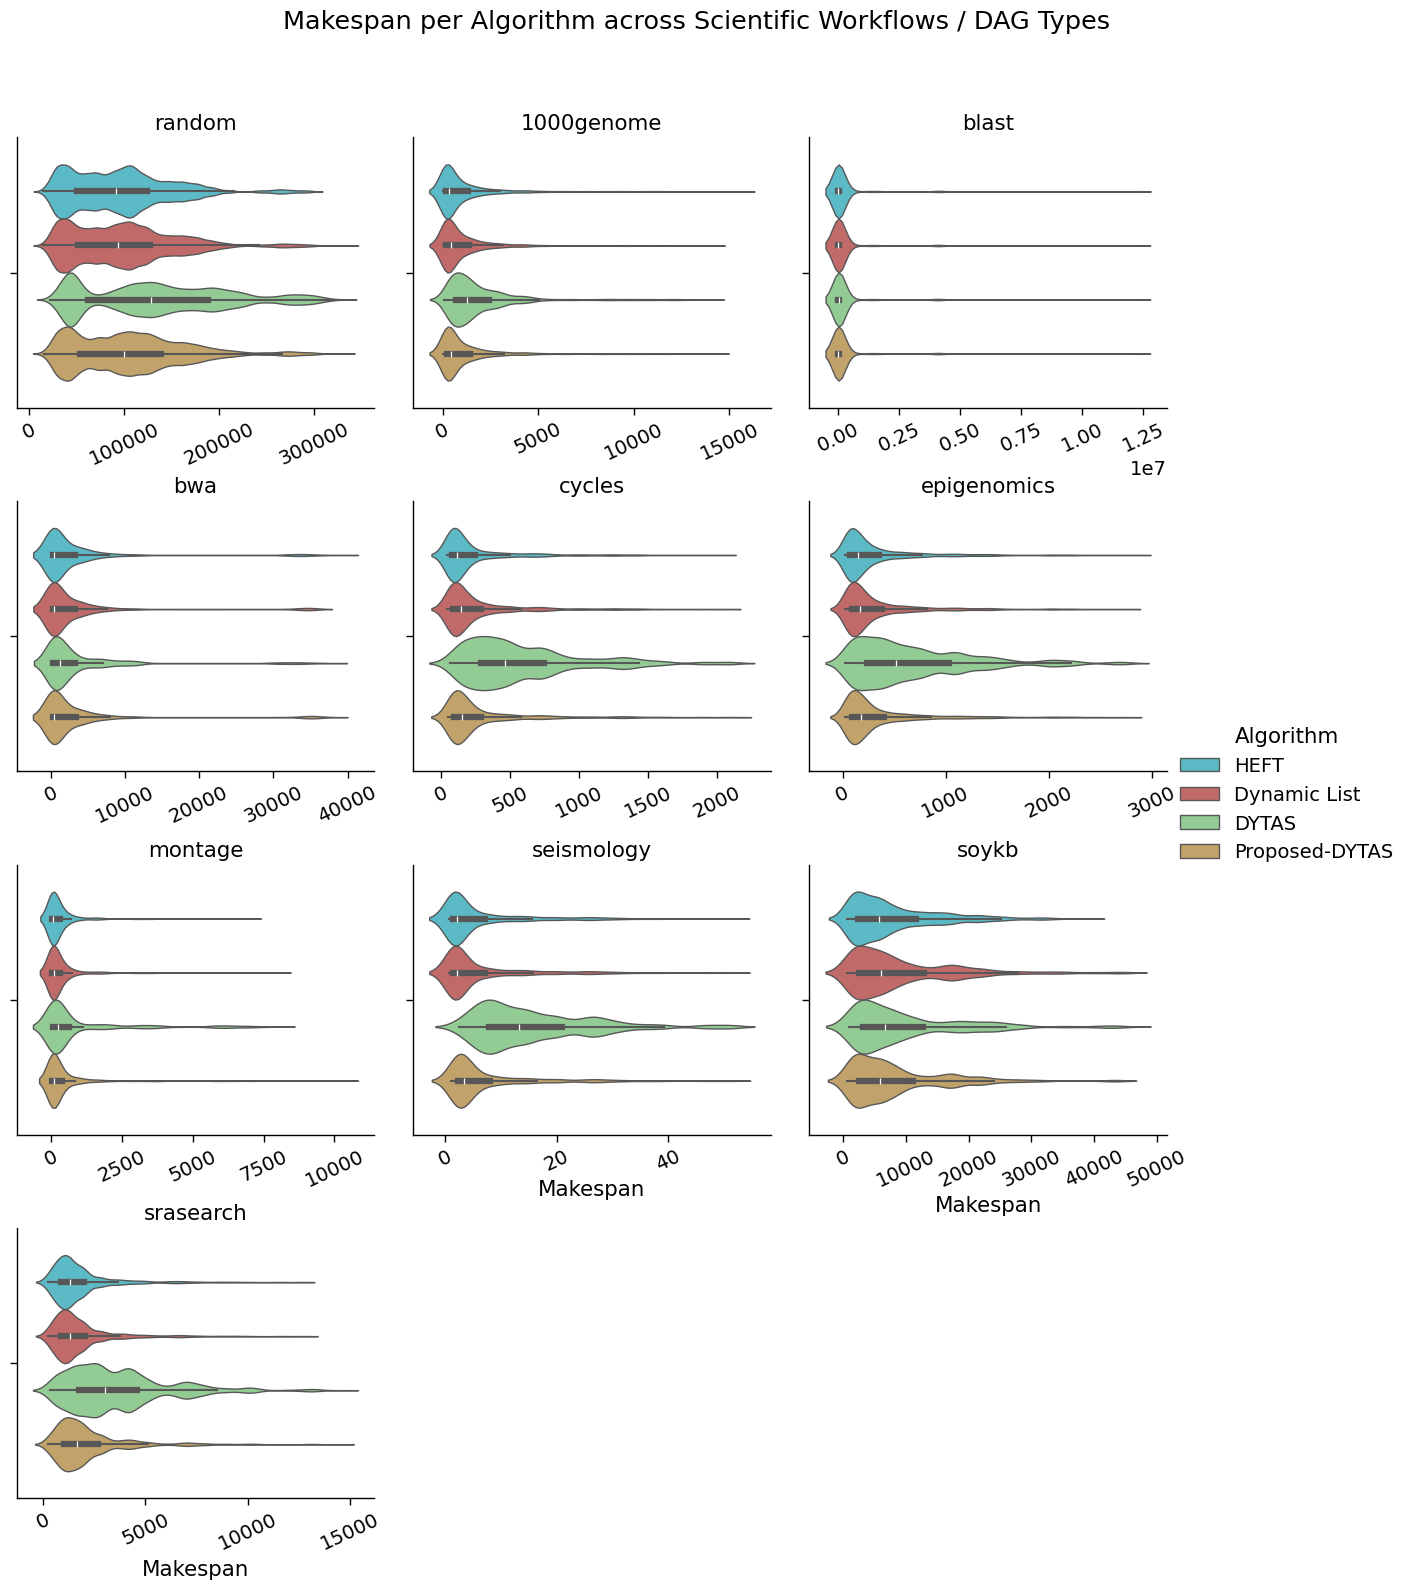

In [200]:

g = sns.FacetGrid(df, col="workflow", col_wrap=3, height=4, sharex=False)
g.map_dataframe(sns.violinplot, x="makespan", hue="scheduler", 
                hue_order=hue_order, palette=cmap, orient='h')

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(25)  # or 45 for more angle

g.add_legend(title="Algorithm")

g.set_axis_labels("Makespan", "")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Makespan per Algorithm across Scientific Workflows / DAG Types")


plt.show()


# Algorithm Speedup

<Axes: xlabel='dag_nodes', ylabel='speedup'>

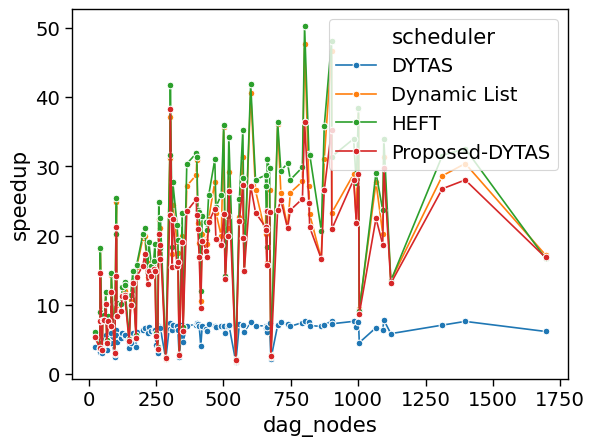

In [157]:
# Calculating the average speedup for pairs of algorithm and nodes


sns.lineplot(
    data=df.groupby(["scheduler", "dag_nodes"])["speedup"].mean().reset_index(),
    y="speedup", x="dag_nodes", hue="scheduler",
    marker='o'
)

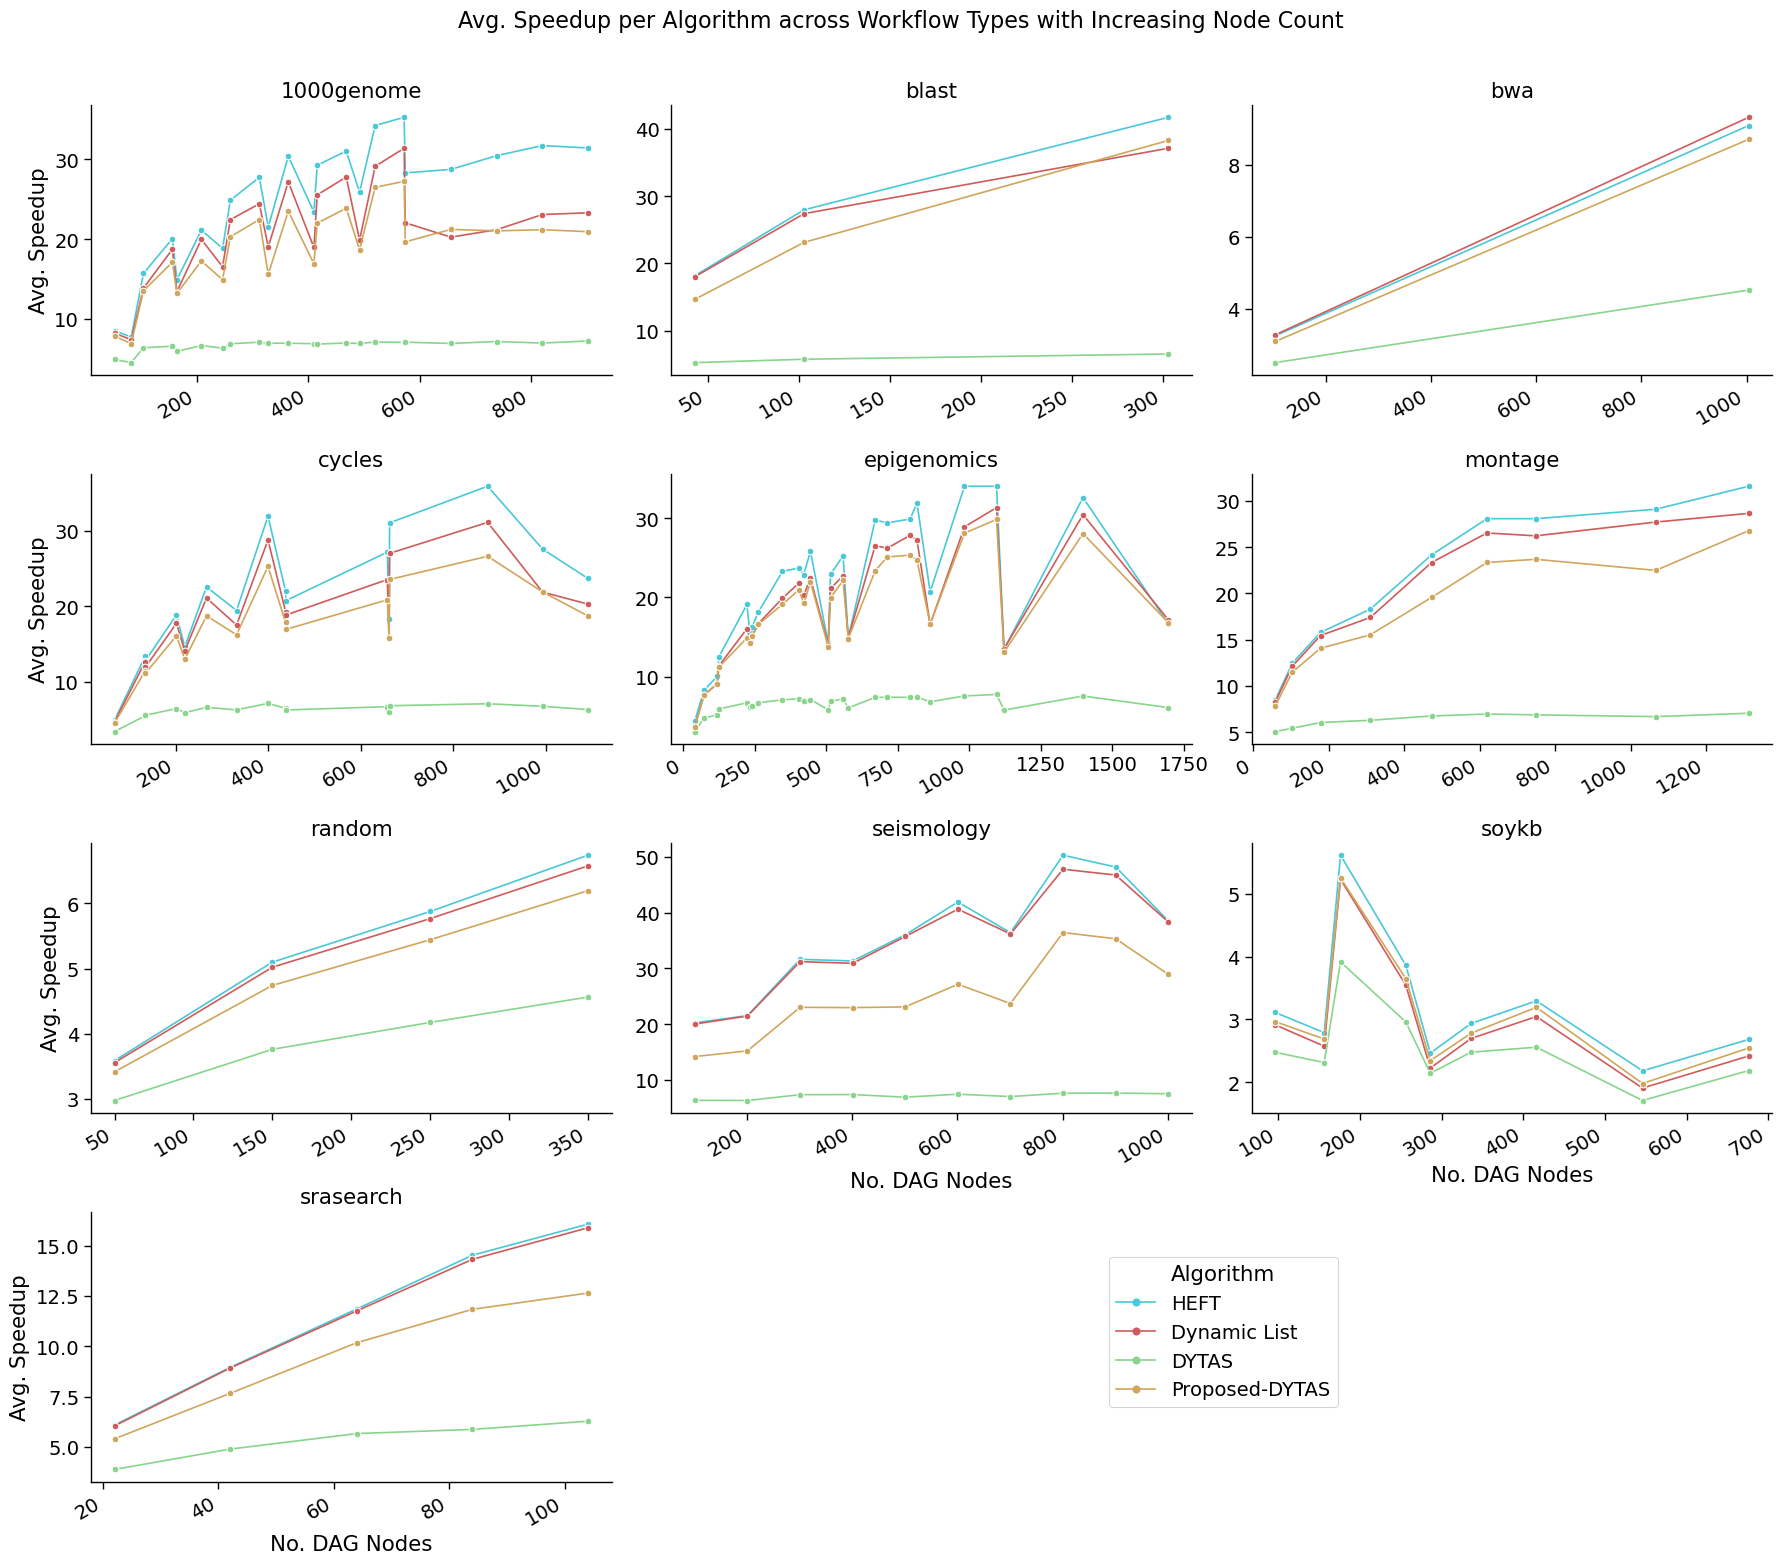

In [192]:
# Prepare the data by grouping and calculating the mean speedup
grouped_df = df.groupby(["workflow", "scheduler", "dag_nodes"])["speedup"].mean().reset_index()

g = sns.relplot(
    data=grouped_df,
    x="dag_nodes",
    y="speedup",
    hue="scheduler",
    kind="line",
    marker="o",
    col="workflow",
    col_wrap=3,
    height=4,
    aspect=1.3,
    hue_order=hue_order, palette=cmap, 
    facet_kws={'sharex': False, 'sharey': False}
)

# Move the legend outside the plot area
sns.move_legend(
    g,
    "lower right",
    bbox_to_anchor=(.75, 0.1),
    frameon=True,
    title="Algorithm"
)

# Adjust layout to accommodate the legend
g.figure.subplots_adjust(right=0.85)

# Set axis labels and titles
g.set_axis_labels("No. DAG Nodes", "Avg. Speedup")
g.set_titles("{col_name}")

# Rotate x-axis tick labels for better readability
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")

# Add a main title to the figure
g.figure.suptitle("Avg. Speedup per Algorithm across Workflow Types with Increasing Node Count", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()



# Algorithm efficiency

In [136]:
figsize=(5,5)

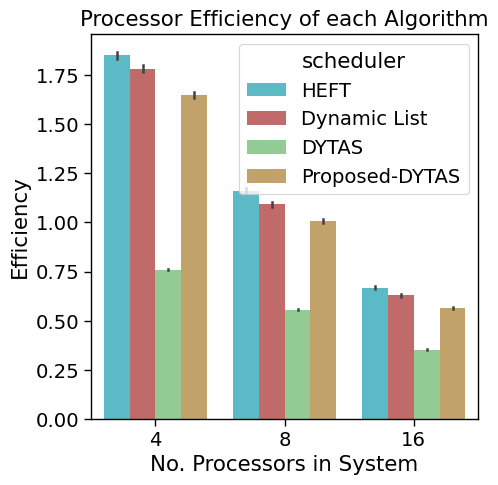

In [137]:

plt.figure(figsize=figsize)
sns.barplot(data=df, x="processor_count", y="efficiency_processors",
            hue="scheduler",hue_order=hue_order, palette=cmap)

plt.title("Processor Efficiency of each Algorithm")
plt.xlabel("No. Processors in System")
plt.ylabel("Efficiency")
plt.show()

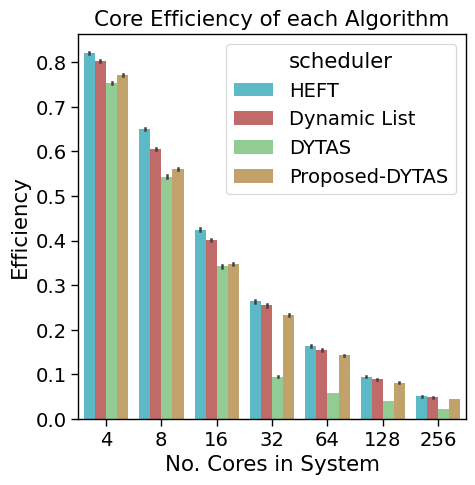

In [139]:

plt.figure(figsize=figsize)
sns.barplot(data=df, x="core_count", y="efficiency_cores", hue="scheduler",
            hue_order=hue_order, palette=cmap)

plt.title("Core Efficiency of each Algorithm")
plt.xlabel("No. Cores in System")
plt.ylabel("Efficiency")
plt.show()

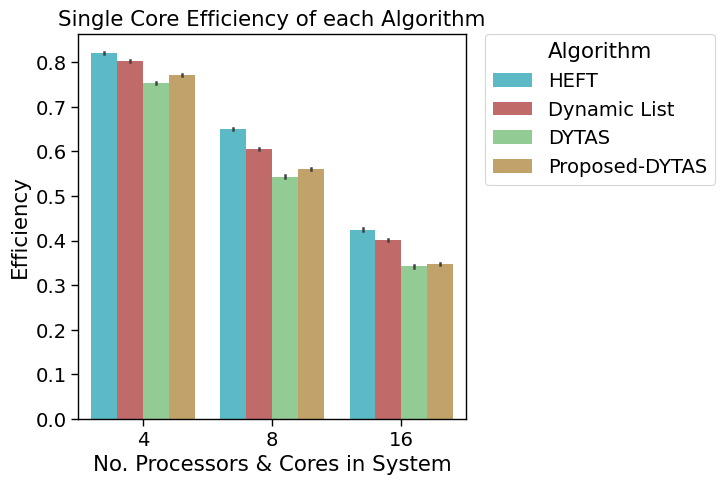

In [142]:
plt.figure(figsize=figsize)
sns.barplot(data=df[df.processor_count == df.core_count], x="processor_count", y="efficiency_processors",
            hue="scheduler",hue_order=hue_order, palette=cmap)

plt.legend(
    title="Algorithm",
    bbox_to_anchor=(1.05, 1),  # X=1.05 (right), Y=1 (top)
    loc='upper left',
    borderaxespad=0.
)

plt.title("Single Core Efficiency of each Algorithm")
plt.xlabel("No. Processors & Cores in System")
plt.ylabel("Efficiency")
plt.show()

# DAG Density

To visualize if it affects makespan in any way shape or form.

To do this, one must control for node count of the DAG, not just workflow. Otherwise it is difficult to notice the effects of a DAG with the same number of nodes, but just more connections.

In [193]:
df[df.workflow == "random"]["dag_nodes"].unique()

array([150, 250, 350,  50])

In [194]:
# Using node counts that are particular to the
# random DAGs as those had their density controlled.
node_counts = df[df.workflow == "random"]["dag_nodes"].unique()

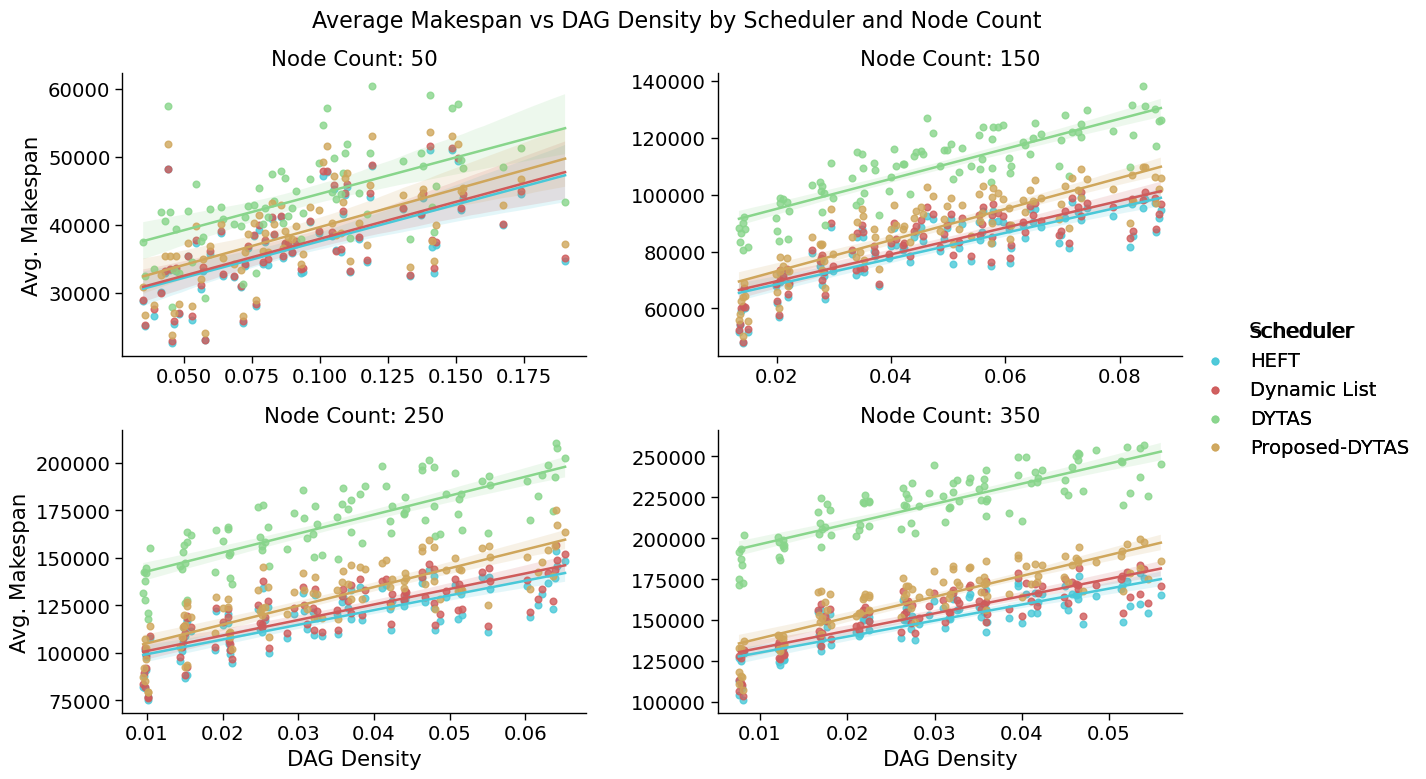

In [210]:
# Step 1: Aggregate the data
df_grouped = (
    df[df.dag_nodes.isin(node_counts)].groupby(
        ["scheduler", "dag_density", "dag_nodes"])
    ["makespan"]
    .mean()
    .reset_index()
)

# Step 2: Create the lmplot with faceting
g = sns.lmplot(
    data=df_grouped,
    x="dag_density",
    y="makespan",
    hue="scheduler",
    col="dag_nodes",
    col_wrap=2,
    height=4,
    aspect=1.3,
    hue_order=hue_order, palette=cmap,
    facet_kws={"sharex": False, "sharey": False}
)

# Step 3: Customize the plot
g.set_axis_labels("DAG Density", "Avg. Makespan")
g.set_titles("Node Count: {col_name}")
g.add_legend(title="Scheduler")

# Optional: Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average Makespan vs DAG Density by Scheduler and Node Count", fontsize=16)

plt.show()


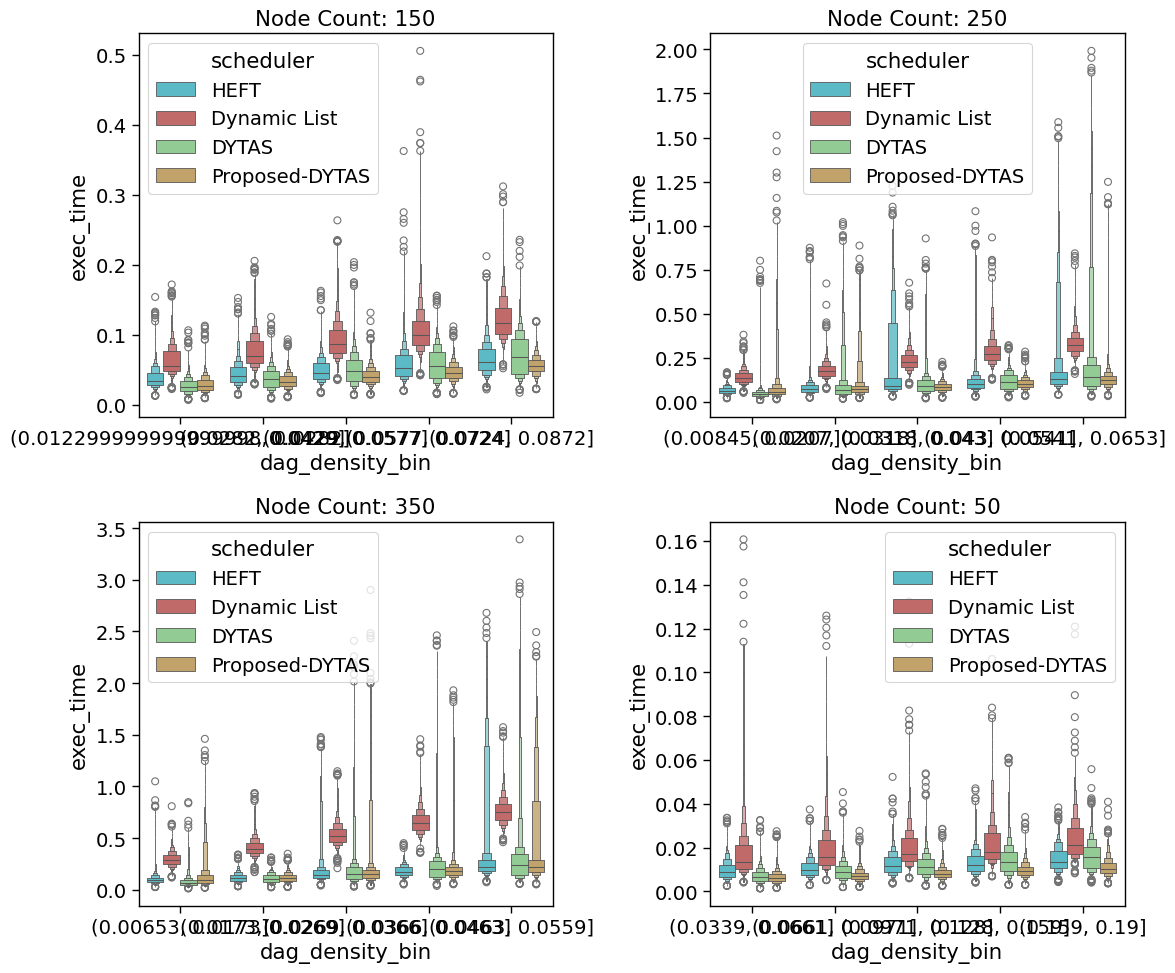

In [212]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, node_count in zip(axes.flatten(), node_counts):
    data = df[(df.dag_nodes == node_count)].copy()
    data["dag_density_bin"] = pd.cut(data["dag_density"], 5, include_lowest=True)
    sns.boxenplot(
        data=data,
        x="dag_density_bin", y="exec_time", hue="scheduler",
        dodge=True, ax=ax,
        hue_order=hue_order, palette=cmap,
    ).set(title="Node Count: " + str(node_count))
    
plt.tight_layout()
plt.show()

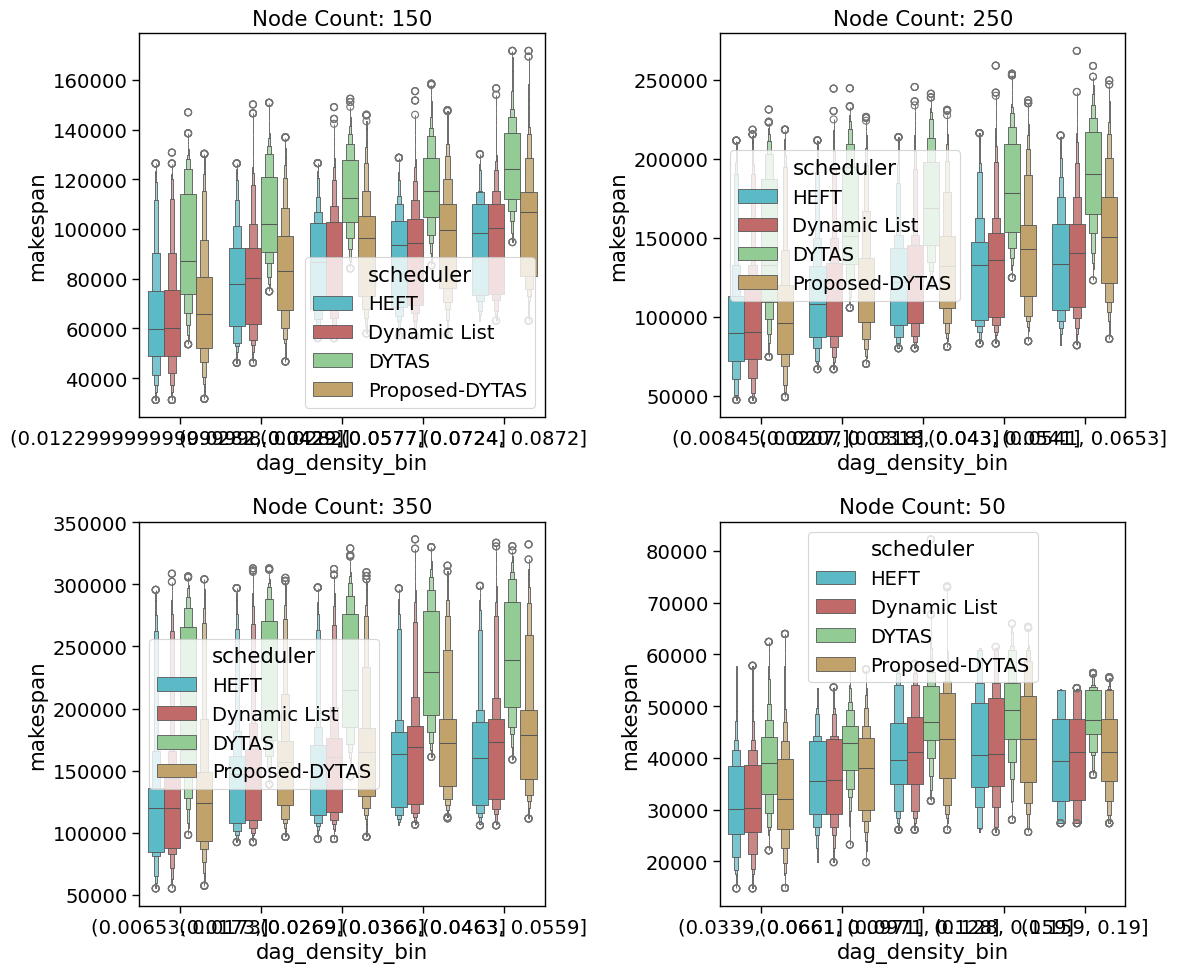

In [215]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, node_count in zip(axes.flatten(), node_counts):
    data = df[(df.dag_nodes == node_count)].copy()
    data["dag_density_bin"] = pd.cut(data["dag_density"], 5, include_lowest=True)
    sns.boxenplot(
        data=data,
        x="dag_density_bin", y="makespan", hue="scheduler",
        dodge=True, ax=ax,
        hue_order=hue_order, palette=cmap,
    ).set(title="Node Count: " + str(node_count))
    
plt.tight_layout()
plt.show()

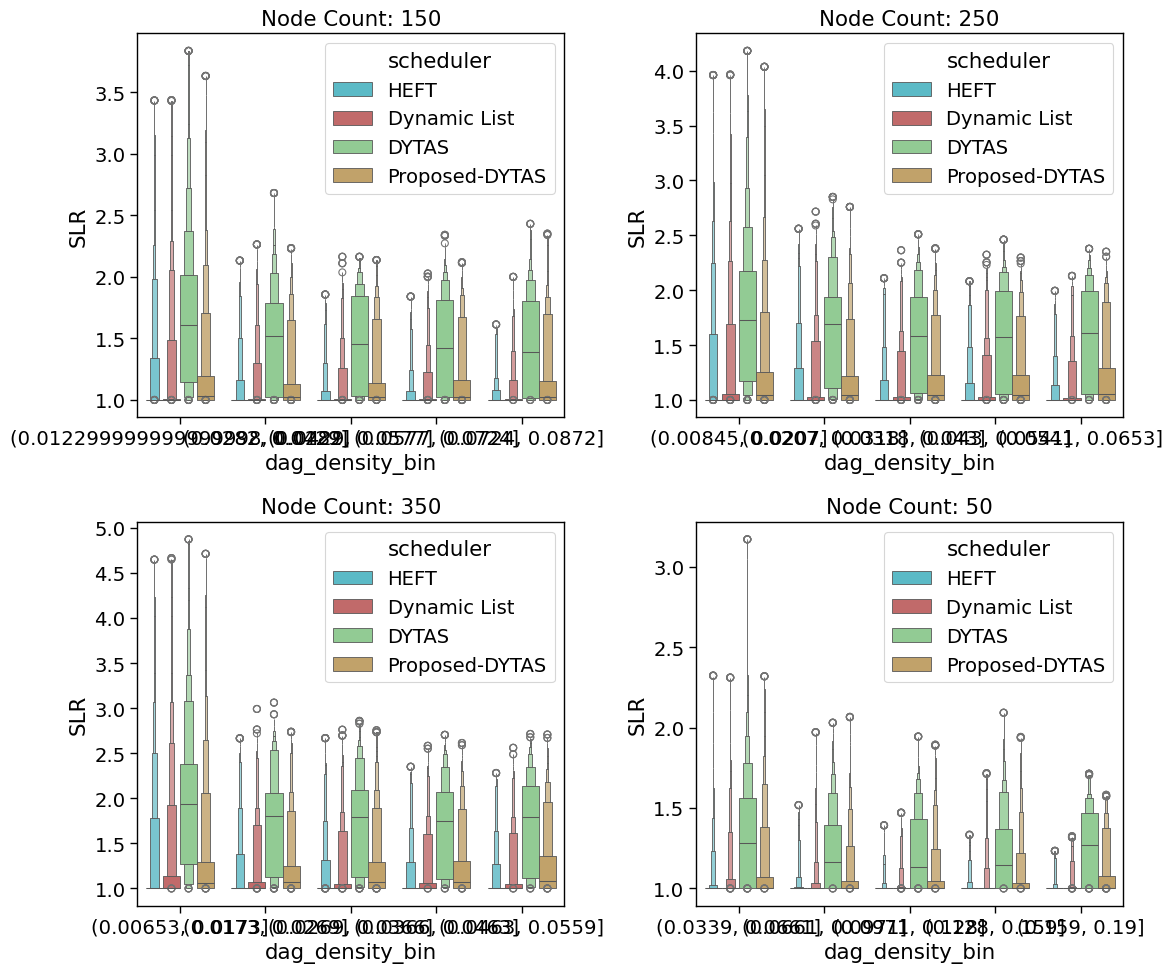

In [216]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, node_count in zip(axes.flatten(), node_counts):
    data = df[(df.dag_nodes == node_count)].copy()
    data["dag_density_bin"] = pd.cut(data["dag_density"], 5, include_lowest=True)
    sns.boxenplot(
        data=data,
        x="dag_density_bin", y="SLR", hue="scheduler",
        dodge=True, ax=ax,
        hue_order=hue_order, palette=cmap,
    ).set(title="Node Count: " + str(node_count))
    
plt.tight_layout()
plt.show()

# Communication to Computation Ratio

<Axes: xlabel='CCR', ylabel='Density'>

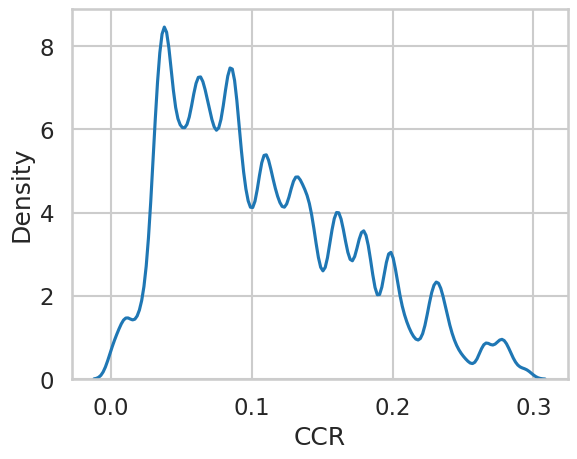

In [251]:
sns.kdeplot(df[df["CCR"] < .3].CCR)

In [235]:
df[df.CCR < 1].workflow.unique()

array(['random', 'blast', 'cycles', 'epigenomics', 'montage',
       'seismology', 'srasearch'], dtype=object)

<Axes: xlabel='CCR', ylabel='Density'>

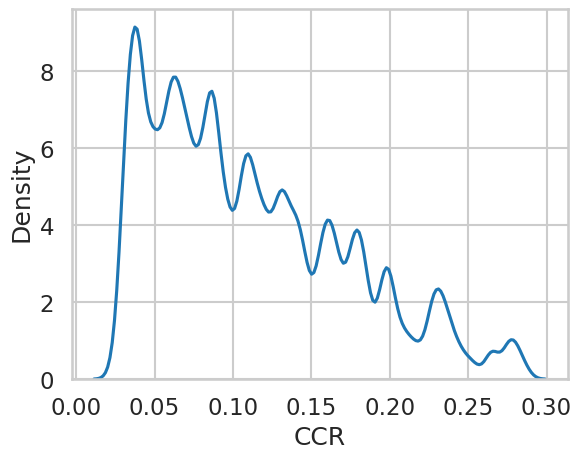

In [236]:
sns.kdeplot(df[df.workflow == "random"].CCR)

I believe that for this particular analysis it would be ideal to only use the random dags...

<Axes: xlabel='CCR', ylabel='Density'>

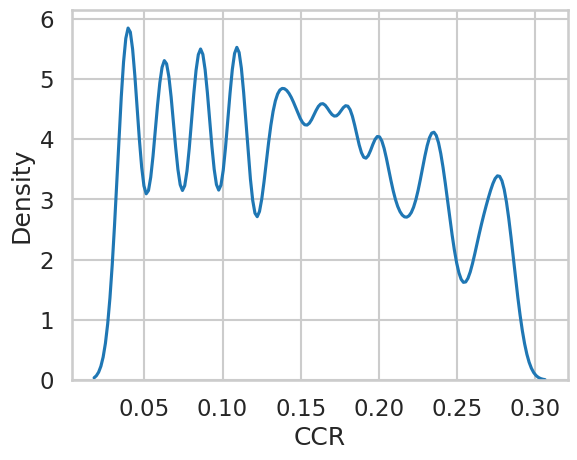

In [240]:
sns.kdeplot(df[df.dag_nodes == 350].CCR)

Or maybe also control for CCR

/tmp/ipykernel_14955/1524760633.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df.CCR < .3].groupby(["scheduler", "CCR_bin"])["makespan"]


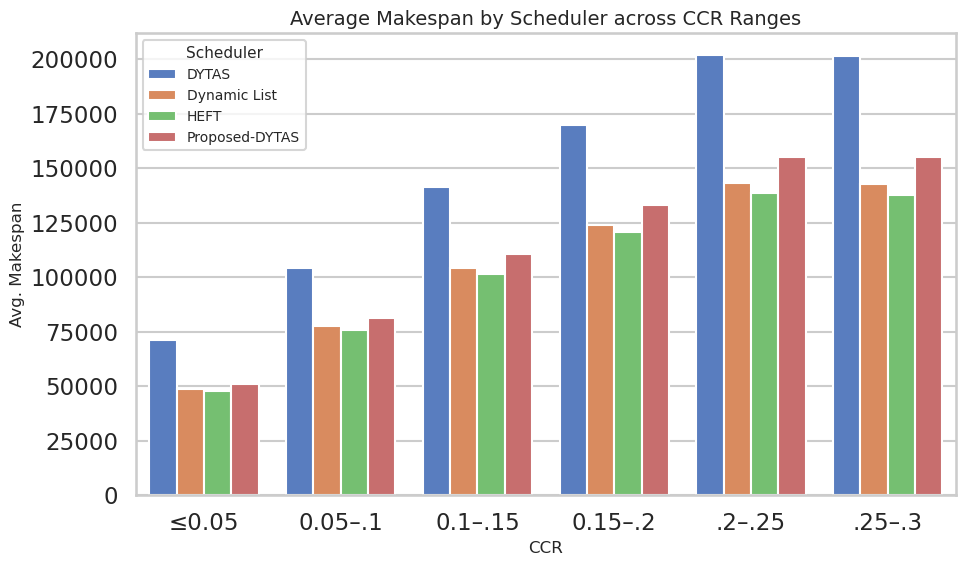

In [255]:
# 1. Bin CCR into 5 fixed ranges (you can tweak these)
bins = [0, 0.05, .1, .15, .2, .25, .3]
labels = ["≤0.05", "0.05–.1", "0.1–.15","0.15–.2", ".2–.25", ".25–.3"]
df["CCR_bin"] = pd.cut(df["CCR"], bins=bins, labels=labels)

# 2. Group by scheduler and CCR bin, compute average makespan
grouped = (
    df[df.CCR < .3].groupby(["scheduler", "CCR_bin"])["makespan"]
    .mean()
    .reset_index()
)

# 3. Plot using seaborn barplot
plt.figure(figsize=(10, 6))
sns.set_context("talk")  # Bigger text
sns.set_style("whitegrid")

sns.barplot(
    data=grouped,
    x="CCR_bin", y="makespan",
    hue="scheduler",
    palette="muted"  # Or try "deep", "Set2", etc.
)

# 4. Labels and legend
plt.xlabel("CCR", fontsize=12)
plt.ylabel("Avg. Makespan", fontsize=12)
plt.title("Average Makespan by Scheduler across CCR Ranges", fontsize=14)
plt.legend(title="Scheduler", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()
